In [40]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from tqdm import tqdm
import spacy 
import warnings
warnings.filterwarnings('ignore')
import sys
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
import pickle
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


In [34]:
import sqlite3
con = sqlite3.connect('./database.sqlite')

In [3]:
# filtering only positive and negetive reviews 
# positive > 3
# negetive < 3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score !=3
""",con)

In [4]:
# Give reviews with Score > 3 a positive rating else negetive
def partition(x):
    if x < 3:
        return 'negetive'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative

In [5]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negetive,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negetive,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
filtered_data.shape

(525814, 10)

In [7]:
display = pd.read_sql_query("""
SELECT *
FROM Reviews 
WHERE Score != 3 AND UserId = 'AR5J8UI46CURR'
ORDER BY ProductID
""",con)
display

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [8]:
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending = True)

In [9]:
# Deduplicatoin of entries
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)

In [10]:
final.shape

(364173, 10)

In [11]:
# how much % of data remain
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [12]:
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]

In [13]:
print(final.shape)

(364171, 10)


In [14]:
final['Score'].value_counts(dropna=True)

positive    307061
negetive     57110
Name: Score, dtype: int64

In [15]:
#Bag of words
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(final['Text'].values)

In [16]:
type(final_counts)

scipy.sparse.csr.csr_matrix

In [17]:
final_counts.get_shape()

(364171, 115281)

In [18]:
#sentence that contain html
import re
i = 0
for sent in final['Text'].values:
    if(len(re.findall('<.*?>',sent))):
        print(i)
        print(sent)
        break
    i+=1

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [19]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ', sentence)
    return cleantext
def cleanpunc(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r'',sentence)
    return cleaned
print(stop)
print('*'*70)
print(sno.stem('tasty'))

{'own', "shouldn't", 'i', 'yourself', 'just', 'through', 'here', 'myself', 'does', 'didn', "didn't", 'not', 'only', 'been', 'too', "doesn't", "weren't", 'for', 'after', 'what', 'my', 'both', "isn't", 'shouldn', 'him', 'then', 'all', 'them', 'having', 'but', "aren't", 'above', 'should', "haven't", 'than', 'an', 'himself', "don't", 'up', 'wasn', 'can', 've', 'about', 'did', 'until', 'those', 'yourselves', 'doing', 'other', 'by', 'which', 'why', "you've", 'll', 'hers', 'where', 'he', 'were', 'now', 'hadn', 'needn', 'mustn', 'do', 'couldn', "won't", 'who', 'you', 'had', 'over', 'few', 'no', 'this', 'very', 'has', "you're", "you'll", 'the', 'at', 'itself', 'once', 'haven', 'o', 'me', 'these', 'was', 'its', 'in', 'yours', 'aren', 're', "she's", 'some', 'is', 'before', 'his', 'm', 'be', "hadn't", 'again', "shan't", "should've", 'or', 'because', 'so', 'will', "you'd", 'ma', 'under', 'whom', 'we', 'mightn', "wasn't", 'our', 'against', 'don', 'your', 'any', 'that', 'such', 'y', 'hasn', "hasn't",

In [20]:
# Code for implementing step-by-step the checks mentioned in teh pre-process 
# this code takes a while to run as it need to run on 500 sentences.
import timeit
start_time = timeit.default_timer()
i = 0
str1 = ' '
final_string = []
all_positive_words = [] # store words from +ve reviews here
all_negetive_words = [] # store words from -ve reviews here

s=''
for sent in final['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent) #remove html tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) and (len(cleaned_words)>2)):
                if(cleaned_words.lower() not in stop):
                    s = (sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive':
                        all_positive_words.append(s) 
                    if (final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue
    str1 = b" ".join(filtered_sentence)
    
    final_string.append(str1)
    i+=1
elapsed = timeit.default_timer()-start_time
print(elapsed)

1155.7502919


In [23]:
final['CleanedText'] = final_string 
final['CleanedText'] = final['CleanedText'].str.decode('utf-8')

In [24]:
final.head(3)

conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
final.to_sql('Reviews',conn, schema=None,if_exists = 'replace',index = True,index_label=None,chunksize = None,dtype = None)

# Time Based Splitting

In [25]:
final = final.sort_values(by=['Time'],ascending=True)
finalDataPoints = final
x = finalDataPoints['CleanedText']
y = finalDataPoints['Score']

In [26]:
final = pd.DataFrame({'score':y,"Text":x})
final.head(5)

,score,Text
138706,positive,witti littl book make son laugh loud recit car...
138683,positive,rememb see show air televis year ago child sis...
417839,positive,beetlejuic well written movi everyth act speci...
346055,positive,twist rumplestiskin captur film star michael k...
417838,positive,beetlejuic excel funni movi keaton hilari wack...


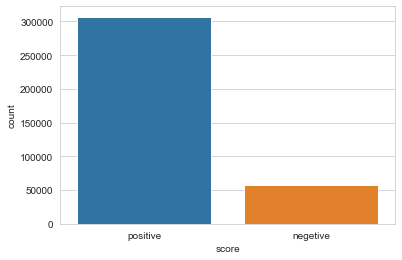

In [29]:
sns.set_style('whitegrid')
ax = sns.countplot(x='score',data = final)

In [30]:
value_count = final['score'].value_counts()
print("{}% data having positive reviews".format(round(value_count[0]/final.shape[0]*100,2)))
print("{}% data having negative reviews".format(round(value_count[1]/final.shape[0]*100,2)))


84.32% data having positive reviews
15.68% data having negative reviews


# NLP
## Bag of words

In [31]:
#unigram
bow = CountVectorizer()
x_unigram = bow.fit_transform(x)

In [49]:
x_unigram.get_shape()


(364171, 113489)

In [56]:
from sklearn.manifold import TSNE
# standardizaton of finalDataPoints
std_data = StandardScaler(with_mean=False).fit_transform(x_unigram)
std_data.shape
# std _data is saprcematrix making it a desematrix T-SNE can't ne apply on sparse matrix
# std_data = std_data.todense()

#plotting TSNE
model = TSNE(n_components=2,random_state = 0, perplexity = 30)
tsne_data = model.fit_transform(std_data)

# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T,finaldatapoint.score)).T
tsne_df = pd.DataFrame(data=tsne_data,columns=('dim1',"dim2","score"))

# ploting the result of tsne
sns.FacetGrid(tsne_df, hue = 'score',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.title("TSNE for Bag of words")
plt.show()

In [ ]:
#bigram
bow_bi = CountVectorizer(ngram_range=(1,2))
x_bigram = bow_bi.fit_transform(x)

In [ ]:
x_bigram = x_bigram.todense()
# TSNE
model = TSNE(n_components = 2,random_state=0,perplexity=30)
tsne_data = model.fit_transform(std_data)

tsne_data = np.vstack((tsne_data.T,finaldatapoint.score)).T
tsne_df = pd.DataFrame(data.tsne_data,columns=('dim1',"dim2","score"))

# ploting the result of tsne
sns.FacetGrid(tsne_df, hue = 'score',size=6).map(plt.scatter,'dim1','dim2').add_legend()
plt.title("TSNE for Bag of words")
plt.show()